<a href="https://colab.research.google.com/github/thiagoteles10/modelo-preditivo-para-aluguel-de-imoveis/blob/main/modelo_preditivo_aluguel_de_im%C3%B3veis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANDO BIBLIOTECAS

In [33]:
!pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [34]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures, SmartCorrelatedSelection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

In [36]:
# CARREGANDO O DATASET

imovel = pd.read_csv('imovel_para_aluguel.csv')

In [37]:
# SUBSTITUINDO OS NOMES DAS VARIÁVEIS
imovel.rename({'city': 'Cidade', 
              'area': 'Área (m²)',
              'rooms': 'Quartos', 
              'bathroom': 'Banheiros', 
              'parking spaces': 'Vagas de Estacionamento', 
              'floor': 'Andar',  
              'animal': 'Animal', 
              'furniture': 'Mobília', 
              'hoa (R$)': 'Condomínio (R$)', 
              'rent amount (R$)': 'Aluguel (R$)', 
              'property tax (R$)': 'IPTU (R$)', 
              'fire insurance (R$)': 'Seguro de Incêndio (R$)', 
              'total (R$)': 'Total (R$)'}, axis='columns', inplace=True)

In [38]:
imovel.replace({'acept': 'Aceita', 
               'not acept': 'Não Aceita', 
               'furnished': 'Mobiliado', 
               'not furnished': 'Não Mobiliado'}, inplace=True)

In [39]:
# FAZENDO SUBSTITUIÇÃO NA VARIÁVEL ANDAR
imovel.replace({'-': 0}, inplace=True)
imovel['Andar'] = imovel['Andar'].astype(int)
imovel['Andar'].dtype

dtype('int64')

In [40]:
imovel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Cidade                   10692 non-null  object
 1   Área (m²)                10692 non-null  int64 
 2   Quartos                  10692 non-null  int64 
 3   Banheiros                10692 non-null  int64 
 4   Vagas de Estacionamento  10692 non-null  int64 
 5   Andar                    10692 non-null  int64 
 6   Animal                   10692 non-null  object
 7   Mobília                  10692 non-null  object
 8   Condomínio (R$)          10692 non-null  int64 
 9   Aluguel (R$)             10692 non-null  int64 
 10  IPTU (R$)                10692 non-null  int64 
 11  Seguro de Incêndio (R$)  10692 non-null  int64 
 12  Total (R$)               10692 non-null  int64 
dtypes: int64(10), object(3)
memory usage: 1.1+ MB


In [41]:
imovel.columns

Index(['Cidade', 'Área (m²)', 'Quartos', 'Banheiros',
       'Vagas de Estacionamento', 'Andar', 'Animal', 'Mobília',
       'Condomínio (R$)', 'Aluguel (R$)', 'IPTU (R$)',
       'Seguro de Incêndio (R$)', 'Total (R$)'],
      dtype='object')

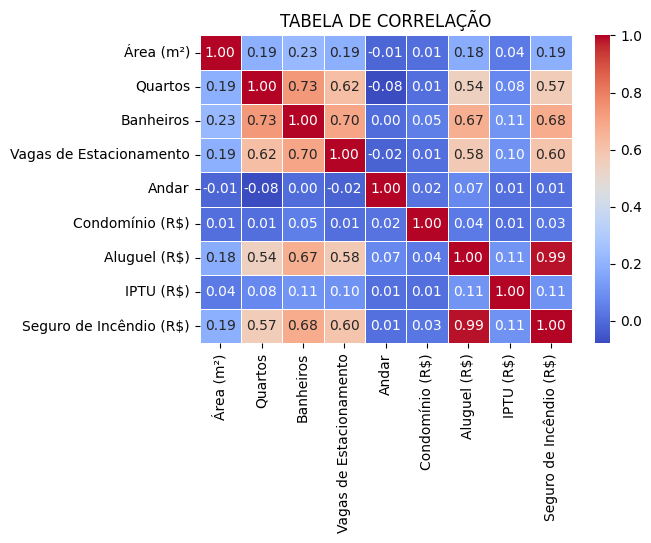

In [42]:
# VERIFICANDO A CORRELAÇÃO DAS VARIÁVEIS E POSSÍVEIS CASOS DE MULTICOLINEARIDADE.
cor_matrix = imovel.drop('Total (R$)',axis=1).corr();
plt.figure(figsize=(6,4));
plt.title('TABELA DE CORRELAÇÃO')
sns.heatmap(cor_matrix, annot=True, linewidths=0.5,fmt='.2f',cmap='coolwarm');

In [43]:
# DIVIDINDO EM VARIÁVEIS CATEGÓRICAS E VARIÁVEIS NUMÉRICAS

categorical_features = ['Cidade','Mobília']
numerical_features = ['Área (m²)', 'Banheiros', 'Vagas de Estacionamento', 'IPTU (R$)', 'Condomínio (R$)','Andar']

In [44]:
#numerical = 'Condomínio (R$)','Área (m²)','Banheiros','Vagas de Estacionamento','IPTU (R$)'
#categoricas = ,

In [45]:
# DIVIDINDO AS FEATURES E O TARGET

X = imovel.drop(['Aluguel (R$)','Seguro de Incêndio (R$)','Total (R$)','Quartos','Animal'],axis=1)
y = imovel['Aluguel (R$)']

In [46]:
# SEPARANDO OS DADOS EM TREINO E TESTE

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [47]:
# CARREGANDO O ALGORITMO

rf = RandomForestRegressor()


In [48]:
# CRIANDO TRATAMENTOS ESPECÍFICOS PARA FEATURES NUMÉRICAS E FEATURES CATEGÓRICAS

numerical_transformer = Pipeline(steps=[
          ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('target', TargetEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numerical_transformer,numerical_features),
        ('cat',categorical_transformer,categorical_features)
    ])

In [49]:
from feature_engine.selection.recursive_feature_elimination import RecursiveFeatureElimination
# RODANDO O PREPROCESSAMENTO, SELEÇÃO DE FEATURES E O MODELO

pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('drop_constant_features',DropConstantFeatures()),
    ('correlated', DropCorrelatedFeatures(method='pearson', threshold=0.75)),
    ('scs', SmartCorrelatedSelection(method='pearson',threshold=0.75)),
    ('rf', rf)])

In [50]:
# TREINADO O MODELO

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Área (m²)', 'Banheiros',
                                                   'Vagas de Estacionamento',
                                                   'IPTU (R$)',
                                                   'Condomínio (R$)',
                                                   'Andar']),
                                                 ('cat',
                                                  Pipeline(steps=[('target',
                                                                   TargetEncoder())]),
                                                  ['Cidade', 'Mobília'])])),
                ('drop_constant_features', DropConstantFeatures()),
                ('correlated', DropCorrelatedFeatures(threshold=0.75)),
                ('scs', SmartCorrelatedSelection(threshold=0.75)),
                ('rf', RandomForestRegressor())])

In [51]:
# CRIANDO PREDIÇÕES NO TESTE PARA AVALIAR O DESEMPENHO
''' o X_test simula dados em produção, é no lugar dele onde entraria um novo dataset para prever os prováveis
valores dos alugueis '''

y_pred = pipe.predict(X_test)
y_pred

array([3387.81, 1469.44, 2953.04, ..., 4957.35, 4398.3 , 4272.98])

In [52]:
# MOSTRANDO AS MÉTRICAS DO MODELO

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('r2 :', r2)
print('MAE:', mae)
print('MSE:', mse)
print('RMSE:', rmse)


r2 : 0.6216938484945285
MAE: 1234.2672973023416
MSE: 4108495.6802451676
RMSE: 2026.942446209356


In [53]:
y_pred.mean()

3887.7812688927693

In [54]:
y_test.mean()

3810.2278678304237

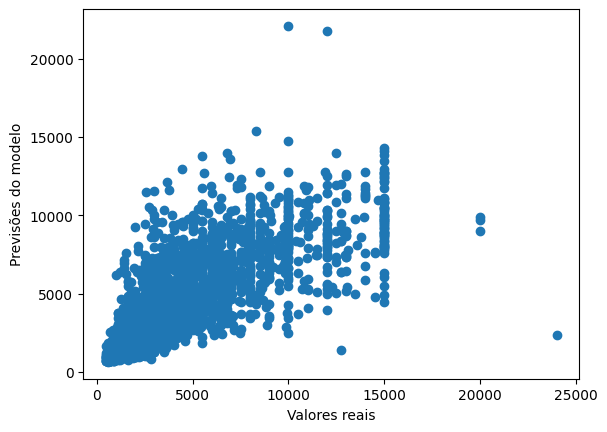

In [55]:
# PLOTANDO UMA COMPARAÇÃO ENTRE OS VALORES REAIS E AS PREVISÕES DO MODELO

import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reais')
plt.ylabel('Previsões do modelo')
plt.show()


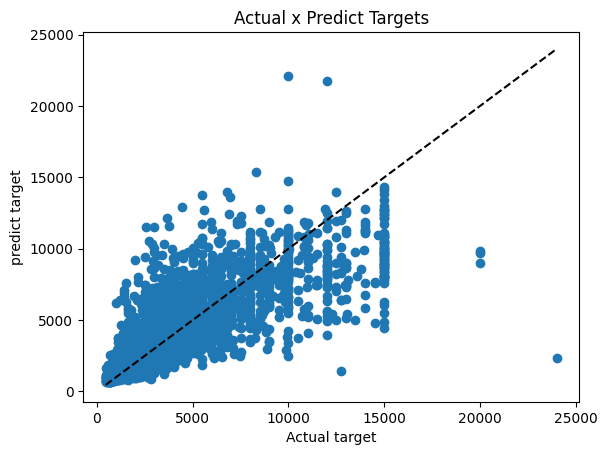

In [56]:
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--',color='black')
plt.xlabel('Actual target')
plt.ylabel('predict target')
plt.title('Actual x Predict Targets')
plt.show()

In [57]:
# FAZENDO UMA VALIDAÇÃO CRUZADA 

from sklearn.model_selection import cross_val_score

# Realizando a validação cruzada com 5 subconjuntos de treinamento/teste:
scores = cross_val_score(pipe, X, y, cv=5, scoring='r2')

# Imprimindo as métricas de desempenho para cada subconjunto de teste:
print("R² scores: ", scores)
print("Média de R²: ", scores.mean())
print("Desvio padrão de R²: ", scores.std())


R² scores:  [0.65163472 0.61289313 0.63297109 0.59594666 0.61287484]
Média de R²:  0.621264087552969
Desvio padrão de R²:  0.019187777279786638
